# Cài đặt YOLOv2

Nguồn tham khảo:
- https://www.kaggle.com/trungthanhnguyen0502/yolo-v2-from-scratch/notebook
- https://www.maskaravivek.com/post/yolov2/


### Outline:
- [0. Chuẩn bị dữ liệu](#0)
- [1. Anchor box clustering với thuật toán K-Means](#1)
- [2. Xử lý Input và Label](#2)
- [3. Lớp MyGenerator](#3)

<a name='0'></a>
## 0. Chuẩn bị dữ liệu

Ta sẽ sử dụng tập dữ liệu <a href="http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#data">**Pascal VOC 2012**</a>
  

In [1]:
CLASSES = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [6]:
imgs_folder = "VOC2012/JPEGImages/"
anns_folder = "VOC2012/Annotations/"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline

Các annotations gốc đang ở dạng XML nên ta sẽ đọc chúng là lưu vào 1 dictionary.

Hàm `parse_annotation` sẽ được sử dụng lại trong các phần tiếp theo

In [8]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, classes):
    '''
    Argments:
        `ann_dir`: annotations folder
        `img_dir`: images folder
    Return:
        `all_anns`: dictionary of image annotations (1 annotation per image)
        `class_counts`: dictionary (class, the number of obj found)    
    '''
    all_anns = []
    class_counts = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        tree = ET.parse(ann_dir + ann)

        img = {'object':[]}
        
        for ele in tree.iter():
            if 'filename' in ele.tag:
                path_to_image = img_dir + ele.text
                img['filename'] = path_to_image
                # If this image doesn't exist, raise an exception
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)

            # width and height of image
            if 'width' in ele.tag:
                img['width'] = int(ele.text)

            if 'height' in ele.tag:
                img['height'] = int(ele.text)

            # bounding box information: class and coordinates
            if 'object' in ele.tag or 'part' in ele.tag:
                obj = {}
                
                for attr in list(ele):
                    if 'name' in attr.tag:
                        # class
                        obj['name'] = attr.text
                        
                        # If this class is not in CLASSES, skip this element
                        if obj['name'] not in classes:
                            break
                        else:
                            img['object'] += [obj]

                        # Increase the class_count
                        if obj['name'] in class_counts:
                            class_counts[obj['name']] += 1
                        else:
                            class_counts[obj['name']]  = 1

                    # coodinates
                    if 'bndbox' in attr.tag:
                        for tmp in list(attr):
                            if 'xmin' in tmp.tag:
                                obj['xmin'] = int(round(float(tmp.text)))
                            if 'ymin' in tmp.tag:
                                obj['ymin'] = int(round(float(tmp.text)))
                            if 'xmax' in tmp.tag:
                                obj['xmax'] = int(round(float(tmp.text)))
                            if 'ymax' in tmp.tag:
                                obj['ymax'] = int(round(float(tmp.text)))

        # If this image doesn't contain any obj, skip it
        if len(img['object']) > 0:
            all_anns += [img]
                        
    return all_anns, class_counts

In [10]:
all_anns, class_counts = parse_annotation(anns_folder, imgs_folder, CLASSES)
print('No. images (and annotations) =', len(all_anns))

No. images (and annotations) = 17125


In ra một số annotation:

In [12]:
all_anns[:2]

[{'object': [{'name': 'person',
    'xmin': 174,
    'ymin': 101,
    'xmax': 349,
    'ymax': 351}],
  'filename': 'VOC2012/JPEGImages/2007_000027.jpg',
  'width': 486,
  'height': 500},
 {'object': [{'name': 'aeroplane',
    'xmin': 104,
    'ymin': 78,
    'xmax': 375,
    'ymax': 183},
   {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
   {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
   {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
  'filename': 'VOC2012/JPEGImages/2007_000032.jpg',
  'width': 500,
  'height': 281}]

Visualize số lượng object tìm thấy của mỗi class:

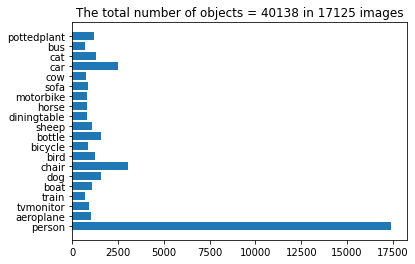

In [18]:
y_ticks = np.arange(len(class_counts))

plt.barh(y_ticks, list(class_counts.values()))

plt.yticks(y_ticks, list(class_counts.keys()))

plt.title("The total number of objects = {} in {} images".format(
    np.sum(list(class_counts.values())), len(all_anns)
))
plt.show()


Với mục đích minh họa thuật toán, ta sẽ chỉ sử dụng tập training và validation:

In [60]:
all_anns = np.array(all_anns)

np.random.seed(666)
np.random.shuffle(all_anns)

ratio = 0.8

train_anns = all_anns[: int(0.8 * len(all_anns))]
val_anns = all_anns[int(0.8 * len(all_anns)):]

<a name='1'></a>
## 1. Anchor box clustering với thuật toán K-Means

Từ các nhược điểm mô YOLOv1 như không dự đoán tốt những vật thể có kích thước khác nhau ở vùng lân cận, YOLOv2 đã sử dụng các anchor box (ý tưởng này thực chất được tham khảo từ các thuật toán RCNN).

Tại mỗi ô lưới sẽ có một số lượng anchor box nhất định, từ đó làm cơ sở để dự đoán các bounding box cho đối tượng nào đó. 

***Ví dụ***: Sử dụng anchor box có kích thước rộng + thấp sẽ có khả năng xác định được những vật thể dạng như chiếc xe ô tô

Ta cần xác định trước những siêu tham số sau:
- Số lượng anchor box
- Kích thước của các anchor box

Ta không nên chọn "bằng tay" mà cần có một phương pháp để chọn sao cho phù hợp với tập dữ liệu đang dùng. Trong paper của YOLOv2, các tác giả sử dụng thuật toán K-Means. Ta sẽ phân cụm các bounding box có trong label, với:
- Số lượng cụm = Số lượng anchor box sẽ dùng cho YOLOv2
- Mỗi phần tử là vector 2 chiều, có ý nghĩa là (width, height) của anchor box

Độ đo được sử dụng là IOU giữa bounding box trong dữ liệu và tâm của các cụm






#### Lấy ra giá trị width, height của toàn bộ bounding box trong tập dữ liệu

Do kích thước của các ảnh là khác nhau nên ta sẽ chuẩn hóa width, height của các bounding box trong ảnh đó bằng cách chia chúng cho width và height của ảnh

In [62]:
train_wh = []
for ann in train_anns:
    img_width = float(ann['width'])
    img_height = float(ann['height'])
    for obj in ann["object"]:
        # normalize
        w = (obj["xmax"] - obj["xmin"]) / img_width
        h = (obj["ymax"] - obj["ymin"]) / img_height
        train_wh.append([w, h])

train_wh = np.array(train_wh)
print(train_wh.shape)

(31979, 2)


#### Tính IOU

Ta chỉ dựa vào các thông tin width, height của 2 box để tính IOU, do đó ta xem chúng có chung đỉnh top-left.

In [42]:
def iou(box1, box2):
    '''
    Compute the IOU value of `box1` and `box2`
    Arguments:
        `box1` and `box2`: a numpy array of shape (2,), indicates [w, h]
    Return:
        IOU value
    '''
    x = np.minimum(box1[0], box2[0]) 
    y = np.minimum(box1[1], box2[1])

    intersection = x * y
    box1_area = box1[0] * box1[1]
    box2_area = box2[0] * box2[1]
    union = box1_area + box2_area - intersection

    return intersection / union

#### Thuật toán K-Means

Lưu ý rằng ta sẽ sử dụng độ đo IOU (thay vì Euclid như bản gốc) và phép cập nhật clusters sẽ dùng median (thay vì mean)

In [51]:
import sklearn
from sklearn.metrics import pairwise_distances

def isConverged(X_old, X_new):
    return set(tuple(X) for X in X_old) == set(tuple(X) for X in X_new)


def kmeans(boxes, n_cluster, seed=2022):
    '''
    K-means clustering with IOU metric.
    Arguments:
        `boxes`: a numpy array of shape (N, 2), indicates [w, h]
        `n_cluster`: the number of clusters
        `seed`: random seed
    Return:
        `clusters`: a numpy array of shape (`n_cluster`, 2)
        `labels`: a numpy array of shape (N, 1)
        `mean_distances`: the mean value of distances between each box and its cluster centroids
    '''
    n_box = len(boxes)
    np.random.seed(seed)

    # initialize the clusters
    clusters = boxes[np.random.choice(n_box, n_cluster, replace=False)]

    while True:
        # assign labels to each box
        distances = 1 - pairwise_distances(boxes, clusters, metric=iou)
        labels = np.argmin(distances, axis=1)

        # update clusters
        new_cluster = np.zeros((n_cluster, boxes.shape[1]))
        for i in range(n_cluster):
            new_cluster[i] = np.mean(boxes[labels == i], axis=0)

        if isConverged(clusters, new_cluster):
            break
        
        clusters = new_cluster

    mean_distances = np.mean(distances[np.arange(n_box), labels])
    return clusters, labels, mean_distances

Chạy K-Means với giá trị k từ 2 đến 8 để tìm ra giá trị tốt nhất:

In [80]:
results = {}
for k in range(2, 9):
    clusters, labels, mean_dist = kmeans(train_wh, k)

    result = {"clusters": clusters,
              "labels": labels,
              "mean_dist":  mean_dist}

    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(
        k, 1 - mean_dist))

    results[k] = result


 2 clusters: mean IoU = 0.4649
 3 clusters: mean IoU = 0.5386
 4 clusters: mean IoU = 0.5800
 5 clusters: mean IoU = 0.6016
 6 clusters: mean IoU = 0.6221
 7 clusters: mean IoU = 0.6431
 8 clusters: mean IoU = 0.6578


Visualize kết quả K-Means và chọn giá trị k với ***Eblow method***

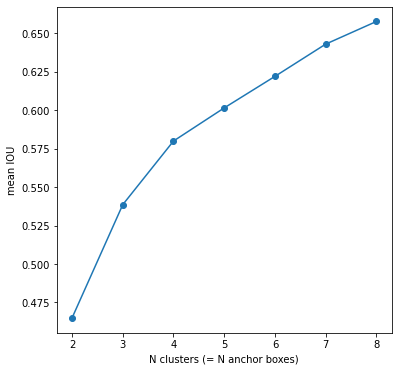

In [81]:
plt.figure(figsize=(6,6))

plt.plot(np.arange(2, 9),
         [1 - results[k]["mean_dist"] for k in range(2, 9)],"o-")

plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

Dựa vào biểu đồ trên, ta chọn **k = 4**

In [82]:
n_anchor_box = 4
results[n_anchor_box]["clusters"]

array([[0.08264212, 0.13575117],
       [0.41898774, 0.6221668 ],
       [0.80433065, 0.77523612],
       [0.20665115, 0.3896164 ]])

Để ý rằng:
- (0.08264212, 0.13575117) $\rightarrow$ anchor box rất nhỏ
- (0.20665115, 0.3896164) $\rightarrow$ anchor box nhỏ
- (0.41898774, 0.6221668) $\rightarrow$ anchor box vừa
- (0.80433065, 0.77523612) $\rightarrow$ anchor box lớn

Các giá trị này sẽ được ta sử dụng trong các phần tiếp theo

In [89]:
ANCHORS = results[n_anchor_box]["clusters"]
print(ANCHORS)

[[0.08264212 0.13575117]
 [0.41898774 0.6221668 ]
 [0.80433065 0.77523612]
 [0.20665115 0.3896164 ]]


<a name='2'></a>
## 2. Xử lý Input và Label

### 2.1. Input encoding

Với mỗi ảnh đầu vào, ta sẽ resize nó về 1 kích thước (416 x 416 hoặc 608 x 608). Khi đó, các tọa độ $x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$ của các bounding box cũng sẽ được rescale theo.

***Ví dụ***: Ảnh gốc 600 x 800, tọa độ $x_{min}$ là 200. Ta resize ảnh về 416 x 416. Khi đó
$$ x_{min} \to \frac{x_{min}}{600} * 416$$

In [85]:
import copy

def normalize(image):
    return image / 255.

class ImageReader(object):
    def __init__(self, img_size=416, norm=normalize):
        '''
        Arguments:
            `img_size`: width and height of image (416 or 608)
            `norm`: normalization method
        '''
        self.img_size = img_size
        self.norm = norm

    def fit(self, img_ann):
        '''
        Arguments:
            `img_ann`: a dictionary contains the annotation of an image
        Return:
            `image`: cv2 image that is resized and normalized
            `all_obj`: a list of dictionarys about name and coordinates of objects
        '''
        img_name = img_ann['filename']

        image = cv2.imread(img_name)

        if image is None:
            print('Cannot find ', img_name)
            return

        img_h, img_w, img_c = image.shape

        # Resize and normalize the image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image[:, :, ::-1]
        if self.norm:
            image = self.norm(image)

        # Rescale object coordinates
        if "object" in img_ann.keys():
            all_objs = copy.deepcopy(img_ann['object'])

            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.img_size) / img_w)
                    obj[attr] = max(min(obj[attr], self.img_size), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.img_size) / img_h)
                    obj[attr] = max(min(obj[attr], self.img_size), 0)
        else:
            return image

        return image, all_objs


Chạy thử lớp `ImageReader`

Input
  object: [{'name': 'person', 'xmax': 287, 'xmin': 242, 'ymax': 220, 'ymin': 125}]
  filename: VOC2012/JPEGImages/2012_000169.jpg
  height: 375
  width: 500
Output
  [{'name': 'person', 'xmax': 238, 'xmin': 201, 'ymax': 244, 'ymin': 138}]


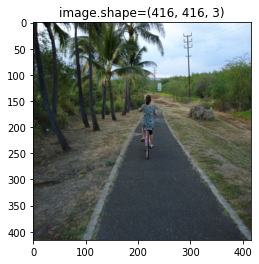

In [86]:
print("Input")
timage = train_anns[0]
for key, v in timage.items():
    print(f"  {key}: {v}")

print("Output")
inputEncoder = ImageReader(img_size=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print(f"  {all_objs}")

plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

### 2.2. Label encoding

### 2.2.1. Từ tọa độ pixel đến tọa độ tương đối
Đối với các thuật toán YOLO, ta không sử dụng các tọa độ $x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$ của các bounding box làm label mà là $x_{center}, y_{center}, width, height$

YOLOv1 xem các đỉnh top-left và bottom-right của mỗi ô lưới tương ứng với các ô (0,0), (1,1). Từ đó, các giá trị tọa độ tâm sẽ được scale về trong các ô lưới chứa nó. Width và height thì sẽ chuẩn hóa về (0,1) dựa theo kích thước ảnh.

Trong phiên bản cài đặt YOLOv2 này, để thuận tiện, ta sẽ thực hiện theo một phương pháp khác:
- Theo paper gốc, ta sử dụng lưới 13 x 13 cho bức ảnh size 416 hoặc 608
- Ta sẽ rescale cả 4 giá trị tọa độ x, y, width, height về [0,13]
    - ***Ví dụ***: Bounding box có width là 150 pixel. Khi đó ta rescale thành $$\frac{150}{416} * 13 = 4.6875$$


In [87]:
def rescale_box(box, img_size=416, grid_size=13):
    '''
    Rescale the box coordinate to our method
    Arguments:
        `box`: an array of shape (4,), indicates [xmin, ymin, xmax, ymax] 
        `img_size`: width and height of image (416 or 608)
        `grid_size`: the number of grid cells on horizontal (or vertical)
    Return:
        `rescaled_box`: a numpy array of shape (4,)
    '''
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    rescaled_box = np.array([x, y, w, h])
    rescaled_box = rescaled_box * grid_size / img_size
    return rescaled_box

### 2.2.2. Label của các anchor box

Kích thước của input, output của YOLOv2 như sau:
- Input: (IMG_SIZE, IMG_SIZE, 3)
- Output: (GRID_SIZE, GRID_SIZE, N_BOX, 4 + 1 + N_CLASS)

Tại mỗi ô lưới, ta sẽ có N_BOX anchor box. Khi đó, nếu trong ô lưới đó có một object A thì trong các anchor box này cần có 1 anchor box chịu trách nhiệm về A, tức là vector (4 + 1 + N_CLASS) chiều tại đó sẽ có giá trị giống với label của object đó (có được từ các annotation).

Tiêu chí chọn ra anchor box phù hợp sẽ là tính IOU giữa anchor box đó với bounding box của object. Hơn nữa, ta sẽ xem chúng có cùng đỉnh top-left là (0, 0), việc tính IOU chỉ cần dựa vào width và height.

Từ đó, ta xây dựng lớp `BestAnchorBoxFinder` như sau:

In [84]:
class BestAnchorBoxFinder:
    def __init__(self, ANCHORS):
        '''
        Arguments:
            `ANCHORS`: a np.array of shape (k, 2) of anchor boxes (found by K-Means)
        '''
        self.anchors = ANCHORS

    def find(self, w, h):
        '''
        Arguments:
            `w`, `h`: width and height of the bounding box
        '''
        best_anchor = -1
        max_iou = -1

        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            cur_iou = iou((w, h), anchor)
            if max_iou < cur_iou:
                best_anchor = i
                max_iou = cur_iou
        return best_anchor, max_iou

## 3. Lớp MyGenerator

Ta sẽ sử dụng lớp này để fetch dữ liệu theo từng batch trong quá trình training. Các ảnh sẽ được đọc trong mỗi lần fetch. Điều này là cần thiết vì số lượng ảnh rất lớn (17125 ảnh), RAM sẽ không thể đủ để đọc toàn bộ ảnh trong 1 lần.

In [78]:
import tensorflow as tf

Để thuận tiện cho việc truyền tham số vào hàm khởi tạo của `MyGenerator`, ta sử dụng dictionary `config` với các thuộc tính sau:
- `IMG_SIZE`: 416 hoặc 608
- `GRID_SIZE`: số lượng ô lưới trên 1 hàng hoặc cột (ví dụ như 13)
- `BATCH_SIZE`
- `CLASSES`: Các class mà ta sẽ train
- `ANCHORS`: mảng 2 chiều, gồm width và height của các anchor box ta tìm được bằng K-Means
- `TRUE_BOX_BUFFER`: Vì ***một lý do nào đó*** mà nguồn mình thao khảo sử dụng thêm tham số này. Đây là số lượng tối đa các bounding box được lưu trữ (từ các bounding box có trong các ảnh) để dùng cho việc tính loss (sẽ đề cập sau)

In [99]:
class MyGenerator(tf.keras.utils.Sequence):
    def __init__(self, anns, config, norm=normalize, shuffle=True):
        '''
        Arguments:
            `anns`: a list of dictionarys about information of each image, such as name and 
                    coordinates of objects
            
            `config` : dictionary containing necessary hyper parameters for traning.
        '''
        self.config = config
        self.n_abox = len(self.config['ANCHORS'])
        self.n_classes = len(self.config['CLASSES'])
        self.anns = anns
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_SIZE'], norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.anns)
            
    def __len__(self):
        return int(np.ceil(len(self.anns) / self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        Arguments:
            `idx`: the index of the batch
        
        Return:
            `x_batch`: a np.array of shape (batch_size, image_size, image_size, 3)
            `y_batch`: a np.array of shape (batch_size, grid_size, grid_size, BOX, 4 + 1 + n_class)
            `b_batch`: a np.array of shape (batch_size, 1, 1, TRUE_BOX_BUFFER, 4)

        Note:
            `b_batch` will be used for calculate loss (?)
        '''

        left = idx * self.config['BATCH_SIZE']
        right = (idx + 1) * self.config['BATCH_SIZE']

        if right > len(self.anns):
            right = len(self.anns)
            left = right - self.config['BATCH_SIZE']

        cnt = 0
        
        x_batch = np.zeros((right - left, self.config['IMAGE_SIZE'], self.config['IMAGE_SIZE'], 3))
        b_batch = np.zeros((right - left, 1, 1, 1,  self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros((right - left, self.config['GRID_SIZE'],  self.config['GRID_SIZE'], self.n_abox, 4 + 1 + self.n_classes))

        for ann in self.anns[left:right]:
            img, all_objs = self.imageReader.fit(ann)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if  obj['name'] in self.config['CLASSES']:
                    tmp = (obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
                    x_new, y_new, w_new, h_new = rescale_box(tmp, img_size=self.config['IMAGE_SIZE'], grid_size=self.config['GRID_SIZE'])
                    
                    grid_x = int(np.floor(x_new))
                    grid_y = int(np.floor(y_new))

                    if grid_x < self.config['GRID_SIZE'] and grid_y < self.config['GRID_SIZE']:
                        class_indx  = self.config['CLASSES'].index(obj['name'])
                        box = [x_new, y_new, w_new, h_new]
                        best_anchor, max_iou = self.bestAnchorBoxFinder.find(w_new, h_new)

                        # assign the label to y_bacth
                        # coodinates
                        y_batch[cnt, grid_y, grid_x, best_anchor, 0:4] = box
                        # confidence
                        y_batch[cnt, grid_y, grid_x, best_anchor, 4] = 1.
                        # class probability
                        y_batch[cnt, grid_y, grid_x, best_anchor, 5 + class_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[cnt, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[cnt] = img
            cnt += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

Chạy thử lớp `MyGenerator`

In [91]:
tmp_config = {
    'IMAGE_SIZE': 416,
    'GRID_SIZE': 13,
    'ANCHORS': ANCHORS,
    'CLASSES': CLASSES,
    'BATCH_SIZE': 32,
    'TRUE_BOX_BUFFER': 50,
}

In [100]:
train_generator = MyGenerator(train_anns, tmp_config, norm=normalize, shuffle=True)

In [104]:
[x_batch, b_batch], y_batch = train_generator.__getitem__(idx=0)
print("x_batch = {}".format(x_batch.shape))
print("y_batch = {}".format(y_batch.shape))
print("b_batch = {}".format(b_batch.shape))

x_batch = (32, 416, 416, 3)
y_batch = (32, 13, 13, 4, 25)
b_batch = (32, 1, 1, 1, 50, 4)


Thử visualize một vài ảnh cùng với bounding boxes

In [159]:
import copy

def plot_img(idx):
    img = copy.deepcopy(x_batch[idx])
    color_cnt = 0
    for grid_i in range(tmp_config["GRID_SIZE"]):
        for grid_j in range(tmp_config["GRID_SIZE"]):
            for anchor in range(len(tmp_config["ANCHORS"])):
                vec = y_batch[idx, grid_i, grid_j, anchor, :]
                conf = vec[4]
                if conf == 1:
                    img_class = np.array(CLASSES)[np.where(vec[5:])][0]

                    x, y, w, h = vec[:4]
                    mult = tmp_config["IMAGE_SIZE"] / tmp_config["GRID_SIZE"]
                    xmin = int((x - 0.5 * w) * mult)
                    ymin = int((y - 0.5 * h) * mult)
                    xmax = int((x + 0.5 * w) * mult)
                    ymax = int((y + 0.5 * h) * mult)

                    cv2.rectangle(img, (xmin, ymin), (xmax, ymax),
                                  color=(0, 255, 0), thickness=3)
                    img = cv2.putText(img, text=str(img_class), org=(
                        xmin, ymin - 5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 255, 0), thickness=3)

    plt.imshow(img)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


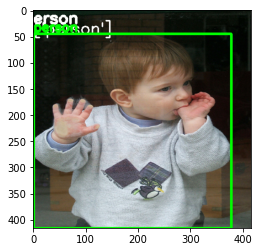

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


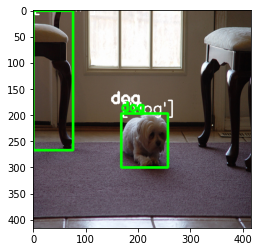

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


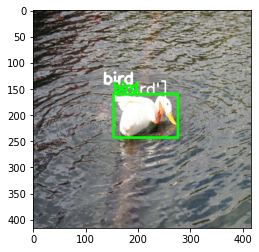

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


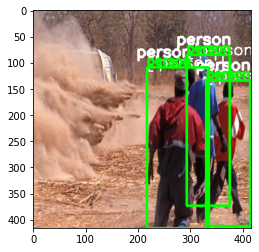

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


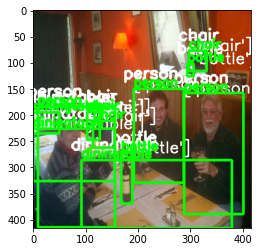

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


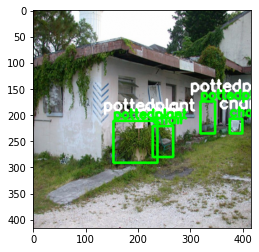

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


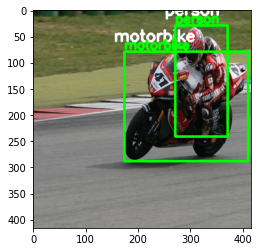

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


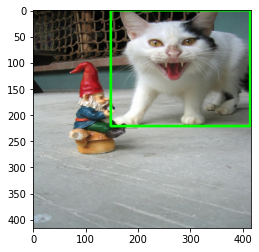

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


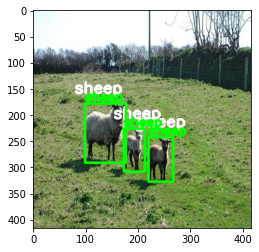

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


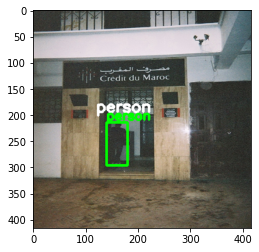

In [160]:
for i in range(10):
    plot_img(i)